In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import datetime
import keras.backend as K

In [36]:
reduction_ratio = 16
epochs = 2000
batch = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 새 섹션

In [37]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [38]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [39]:
test.head()

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4


In [40]:
len(test)

20480

In [41]:
train, val = train_test_split(train, test_size=0.2, random_state=0, stratify=train['digit'])

col_list = [str(i) for i in range(784)]

train_image_df = train[col_list]
val_image_df = val[col_list]
test_image_df = test[col_list]

train_info = train[['id','letter']]
val_info = val[['id', 'letter']]
test_info = test[['id','letter']]
train_label = train['digit']
val_label = val['digit']

train_arr = train_image_df.values.reshape((len(train), 28, 28))
val_arr = val_image_df.values.reshape((len(val), 28, 28))
test_arr = test_image_df.values.reshape((len(test), 28, 28))

print(train_arr.shape, val_arr.shape, test_arr.shape)

(1638, 28, 28) (410, 28, 28) (20480, 28, 28)


In [42]:
train_image_df.shape, val_image_df.shape, test_image_df.shape

((1638, 784), (410, 784), (20480, 784))

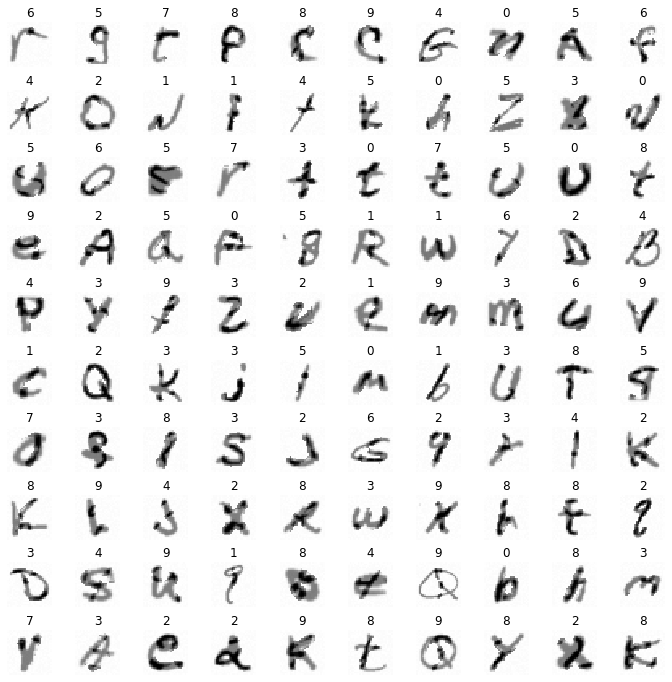

In [43]:
n_rows = 10
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_rows*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(train_arr[index,:,:], cmap='binary', interpolation='nearest')
        plt.axis("off")
        plt.title(str(train_label.values[index]), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [47]:
train_img = train_arr[...,tf.newaxis] # add channel
val_img = val_arr[...,tf.newaxis]
test_img = test_arr[...,tf.newaxis] # add channel

In [48]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1./255.
)

In [49]:
## SE-ResNet
input_ = tf.keras.layers.Input(shape=(28,28,1)) 
conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(input_) #28x28x128


## Residual Unit1
batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
elu1_1 = tf.keras.layers.ELU()(batch1_1)
res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
elu1_2 = tf.keras.layers.ELU()(batch1_2)
res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
elu1_3 = tf.keras.layers.ELU()(batch1_3)
res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

# SEBlock1
ch_input1 = 128
ch_reduced1 = ch_input1//reduction_ratio
avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
#

skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
##

## Residual Unit2
batch2_1 = tf.keras.layers.BatchNormalization()(res1)
elu2_1 = tf.keras.layers.ELU()(batch2_1)
res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
elu2_2 = tf.keras.layers.ELU()(batch2_2)
res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
elu2_3 = tf.keras.layers.ELU()(batch2_3)
res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


# SEBlock2
ch_input2 = 128
ch_reduced2 = ch_input2//reduction_ratio
avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
#
skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
res2 = tf.keras.layers.Add()([mul2, skip2])
drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
##


## Residual Unit3
batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
elu3_1 = tf.keras.layers.ELU()(batch3_1)
res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
elu3_2 = tf.keras.layers.ELU()(batch3_2)
res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
elu3_3 = tf.keras.layers.ELU()(batch3_3)
res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


# SEBlock3
ch_input3 = 128
ch_reduced3 = ch_input3//reduction_ratio
avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
#
skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
##


## Residual Unit4
batch4_1 = tf.keras.layers.BatchNormalization()(res3)
elu4_1 = tf.keras.layers.ELU()(batch4_1)
res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
elu4_2 = tf.keras.layers.ELU()(batch4_2)
res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
elu4_3 = tf.keras.layers.ELU()(batch4_3)
res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


# SEBlock4
ch_input4 = 256
ch_reduced4 = ch_input4//reduction_ratio
avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
#
skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
res4 = tf.keras.layers.Add()([mul4, skip4])
pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
##


## Residual Unit5
batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
elu5_1 = tf.keras.layers.ELU()(batch5_1)
res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
elu5_2 = tf.keras.layers.ELU()(batch5_2)
res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
elu5_3 = tf.keras.layers.ELU()(batch5_3)
res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


# SEBlock5
ch_input5 = 256
ch_reduced5 = ch_input5//reduction_ratio
avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
#
skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
res5 = tf.keras.layers.Add()([mul5, skip5])
pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
##


## Residual Unit6
batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
elu6_1 = tf.keras.layers.ELU()(batch6_1)
res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
elu6_2 = tf.keras.layers.ELU()(batch6_2)
res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
elu6_3 = tf.keras.layers.ELU()(batch6_3)
res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
# SEBlock6
ch_input6 = 256
ch_reduced6 = ch_input6//reduction_ratio
avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
#
skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
res6 = tf.keras.layers.Add()([mul6, skip6])
drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
##

## Residual Unit7
batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
elu7_1 = tf.keras.layers.ELU()(batch7_1)
res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
elu7_2 = tf.keras.layers.ELU()(batch7_2)
res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
elu7_3 = tf.keras.layers.ELU()(batch7_3)
res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
res7 = tf.keras.layers.Add()([res7_3, skip7])
pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) # 2x2x512
##

## Classification Unit
flatten = tf.keras.layers.Flatten()(pool7)
dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten)
drop10 = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(10 ,activation='softmax')(drop10)

In [50]:
model = tf.keras.Model(inputs = [input_], outputs = [output])

In [51]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50)

In [52]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("emnist_best.h5", save_best_only=True, monitor='val_accuracy', mode='auto')

In [54]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(epsilon=1e-04), metrics=["accuracy"],)

In [55]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 28, 28, 128)  3328        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 28, 28, 128)  512         conv2d_67[0][0]                  
__________________________________________________________________________________________________
elu_48 (ELU)                    (None, 28, 28, 128)  0           batch_normalization_49[0][0]     
_______________________________________________________________________________________

In [56]:
history = model.fit_generator(train_datagen.flow(train_img, train_label, shuffle=True, batch_size=batch), epochs=epochs, validation_data=test_datagen.flow(val_img, val_label,batch_size=batch),
                              steps_per_epoch=len(train_img)//batch, validation_steps=len(val_img)//batch, callbacks=[checkpoint_cb])

Epoch 1/2000
51/51 [==============================] - 4s 70ms/step - loss: 4.9415 - accuracy: 0.0928 - val_loss: 2.6321 - val_accuracy: 0.0990
Epoch 2/2000
51/51 [==============================] - 3s 54ms/step - loss: 3.1137 - accuracy: 0.1146 - val_loss: 4.1557 - val_accuracy: 0.1094
Epoch 3/2000
51/51 [==============================] - 2s 45ms/step - loss: 2.9418 - accuracy: 0.1308 - val_loss: 3.0512 - val_accuracy: 0.1042
Epoch 4/2000
51/51 [==============================] - 3s 51ms/step - loss: 2.8363 - accuracy: 0.1445 - val_loss: 6.3339 - val_accuracy: 0.0938
Epoch 5/2000
51/51 [==============================] - 3s 54ms/step - loss: 2.7879 - accuracy: 0.1395 - val_loss: 2.4483 - val_accuracy: 0.1406
Epoch 6/2000
51/51 [==============================] - 3s 53ms/step - loss: 2.6826 - accuracy: 0.1532 - val_loss: 2.4230 - val_accuracy: 0.2422
Epoch 7/2000
51/51 [==============================] - 2s 46ms/step - loss: 2.6692 - accuracy: 0.1519 - val_loss: 2.6447 - val_accuracy: 0.1719

In [57]:
acc = history.history['val_accuracy']
best = np.max(acc)
print(best)

0.9114583134651184


## Model Tuning
- 앞부분 Residual Unit 한 단계만 적용해보기
- output 64인 conv2D layer 늘려야 할듯

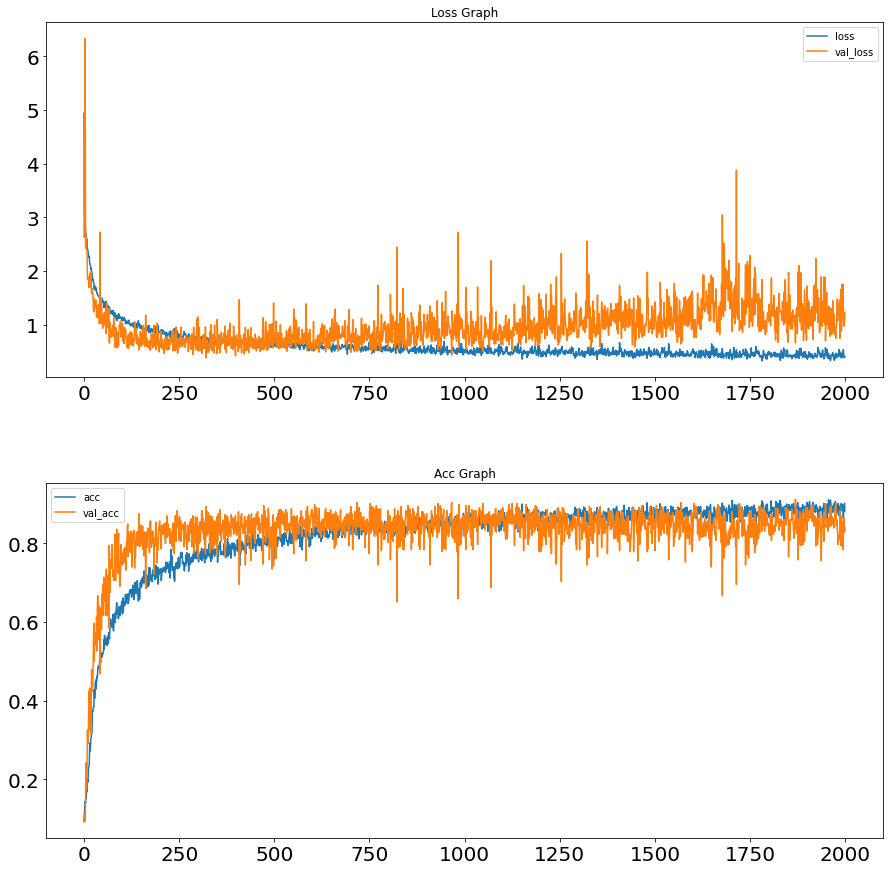

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig, ax = plt.subplots(2, 1, figsize = (15,15))
fig.subplots_adjust(hspace = 0.3)
ax[0].set_title("Loss Graph")
ax[0].plot(loss, label='loss')
ax[0].plot(val_loss, label='val_loss')
ax[0].legend()
ax[0].tick_params(axis = 'both', labelsize = 20)
ax[0].tick_params(axis = 'both', labelsize = 20)
ax[1].set_title("Acc Graph")
ax[1].plot(acc, label='acc')
ax[1].plot(val_acc, label='val_acc')
ax[1].legend()
ax[1].tick_params(axis = 'both', labelsize = 20)
ax[1].tick_params(axis = 'both', labelsize = 20)

In [59]:
np.max(history.history['val_accuracy'])

0.9114583134651184

In [61]:
submission = pd.read_csv('/kaggle/input/dacon-emnist/submission.csv')
test_img = test_img/255.
model = tf.keras.models.load_model('emnist_best.h5')
result = model.predict(test_img)
digit = np.argmax(result, axis=1)
submission.digit = digit
submission.to_csv('sub10.csv', index=False)